(hgf_exercises)=
# An introduction to Hierarchical Gaussian Filters trough practical exercises

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [2]:
from pyhgf import load_data
from pyhgf.model import HGF
from pyhgf.distribution import HGFDistribution
import pandas as pd
import jax.numpy as jnp
import arviz as az

# load an example time series for continuous inputs
timeseries = load_data("continuous")

In this tutorial, we introduce the continuous and binary Hierarchical Gaussian Filters and describe their application in the context of computational psychiatry research.

We start by reviewing the core principles on which the HGF is built: a generative model of embedded stochastic processes to describes hidden states of the world. In the first part, we review the mathematical description of such processes and how to implement them in Python.

In the second part, we apply this model to real world data (weather dataset) by creating an agent that *uses* this model to filter sensory information and update internal beliefs about hidden states of the world. We then try to apply Bayesian inference over some of the agent's parameters.

In the third part we introduce the binary Hierarchical Gaussian filter and consider experimental designs familiar in reiforcement learning, where the agent tries to learn the association between stimuli, or the occurence of binary events. Then again,- we apply Bayesian inference, and try to compare the performamce of our model with alternative explanations of an agent's behaviours.

## Belief updating under uncertainty: the continuous Hierarchical Gaussian Filter
### Gaussian random walks

Hierarchical Gaussian Filters are built on a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) that generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ as its mean such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the fixed variance of the distribution. 

```{admonition} Exercise 1
Using the equation above, write a Python code that implements a Gaussian random walk using the following parameters: $\sigma^2 = 1$ and $x_1^{(0)} = 0$.
```

### Value and volatility coupling between probabilistic nodes

We have simulated above a simple GRW. At each time point, this process is fully described by the probability distribution and the sufficients statistics of this probability distribution (the mean and the variance). Using these values, we can also derive expected values (uising the current mean) and expected precision (using the current variance).

The HGF hierarchically generalize this process by making the parameters of a stochastic process depend on another GRW at a different level. In [PyHGF](https://github.com/ilabcode/pyhgf) we use a *nodalized* version of this framework {cite:p}`weber:2023`, and consider that each stochastic process is a node in a network, connected with other node through probabilistic dependencies: **value coupling** (targetting the value $\mu$ of the child node) or **volatility coupling** (targetting the volatility $\sigma^2$ of the child node).

Let's consider for example a network consitued of two nodes $x_1$ and $x_2$, as it is found in the continuous HGF {cite:p}`2014:mathys`. The node $x_1$ is performing a GRW as previously described. We can add a dependency on the mean of the distribution (**value coupling**) by assuming that $x_1$ inherit this value directly from $x_2$, instead of using its own previous value. Mathematically, this would write:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \sigma_2^2) \\
x_1^{(k)} \sim \mathcal{N}(x_2^{(k)}, \, \sigma_1^2) \\
$$

Note that this generative process reads top-down: the node higher in the hierarchy ($x_2$) generates new values and pass them to the child nodes.

We can also arrange things differently, for example assuming  that $x_1$ runs the GRW as usual, but this time it is paired with $x_2$ via **volatility coupling**. This means that for state $x_1$, the mean of the Gaussian random walk on time point $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(x_2^{(k)} + \omega_1)
$$

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k-1)}, \, \exp(\omega_2))
$$

```{hint}
Here the volatility is not simply inherited from the higher node, it is mixed with another quantity ($\omega_2$). This is because we don't want the parent node to explain all the variance alone, the child node ($x_1$) also has a parameter for it own variance and expect some variability by itself. The parent node can weight on this by adding or removing variance in the final quantity. $\omega$ is sometimes refered to as the *tonic* part of the variance, or the *evolution rate*, while $x_2$ is the *phasic* part of the variance.
```

```{admonition} Exercise 2
- Using the equation above and your previous implementation, write a Python code that implements a hierarchical Gaussian random walk with the following parameters: $\omega_1 = -6.0$, $\omega_2 = -6.0$, $\mu_1 = 0.0$, $\mu_2 = -2.0$, $x_{1} = 0.0$ and $x_{2} = -2.0$

- What happens when we change the values of $\omega_1$?

- What happens when we change the values of $\omega_2$?
```

### The continuous Hierarchical Gaussian Filter

Hierarchical Filters are built on this notion that we can embed stochatic nodes and make them depends on each others and use this as a generative model of hidden states of the world.

We therefore want to create agents that can use this principle to filter the sensory inputs they receive. But this time we have to think the other way. We do not want to generate data top-down (as in the function you wrote above), we already have the dat in the form of sensory inputs. We want to provide this sensory input to the model and update the probabilistic nodes accordingly, so that they continue to predict the next sensory input reasonably well.

This requires to propagate updates on the sufficient statistics and send prediction-error to the parent nodes. The pyhgf package implements this process with the corresponding update equation so the model can take as input a time series and infer the more likely generative structure that created the values. This can be extremely useful if you want to work with time series that have varying levels of volatility (i.e. meta-volatility). In the following example, we illustrate how we can use the Hierarchical Gaussian Filter to filter and predict inputs in a continuous node.

In [60]:
# create a two-levels continuous HGF
two_levels_continuous_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 0.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -8.0, "2": -1.0},
)

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


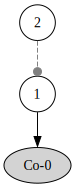

In [61]:
# plot the implied probabilistic network
two_levels_continuous_hgf.plot_network()

In [63]:
# add new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeseries)

Adding 614 new observations.


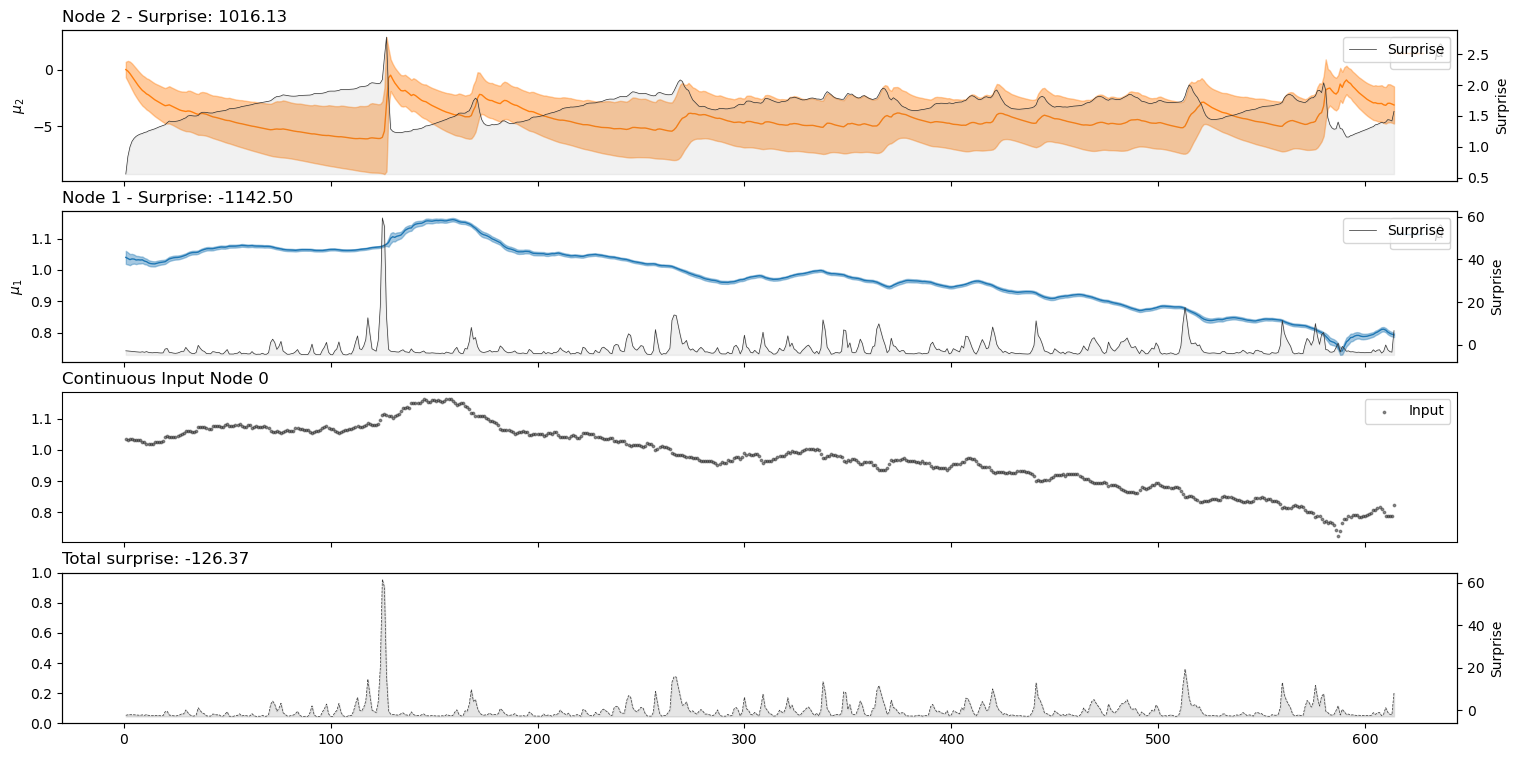

In [64]:
# plot the trajectories of the model beliefs
two_levels_continuous_hgf.plot_trajectories();

In [65]:
# return the sum of surprise at the input node
two_levels_continuous_hgf.surprise()

Array(-1142.5042, dtype=float32)

| parameter | description |
| --- | --- |
| $\mu_i$ | The mean of the distribution in node $i$. |
| $\pi_i$ | The precision of the distribution in node $i$. the precision is the inverse of the variance ($\frac{1}{\sigma^2}$) |
| $\omega_i$ | The evolution rate, or the tonic part of the variance of the distribution in node $i$. |

```{admonition} Exercise 3
$\omega$ represents the tonic part of the variance (the part that is not affected by the parent node). Using the code example above, create another model with different values for $\omega$ at the second level. What is the consequence of changing this value on the beliefs trajectories? What is the "best" model in this context?
```

### Parameters optimization

So far we have been running the HGF forward by fixing the values of the parameters beforehand. This is an important part of the modelling process as we can retrieve the beliefs trajectories, which indicates how the agent might use sensory informations to adapt to the environment, as well as the surprise associated with these observation, which indicates *how well* the agent adapted to the environment. 

In the context of analysing data from a task, we do not want to fit the data manually and retrieve the trajectories from every possible set of parameters. Instead, we want to perform Bayesian inference over these parameter and estimate the posterior of the probability distribution. Here we are going to perform this step using Hamiltonian Monte Carlo sampling as implemented in PyMC.

In [8]:
import pymc as pm
import numpy as np
from pyhgf.distribution import HGFDistribution
from pyhgf.response import first_level_gaussian_surprise

hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=[timeseries],
    response_function=first_level_gaussian_surprise
)

In [9]:
with pm.Model() as two_level_hgf:

    # omegas priors
    omega_1 = pm.Uniform("omega_1", -20, -2.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-2.0,
            continuous_precision=1e4,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=timeseries[0],
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=np.nan,
            rho_3=np.nan,
            pi_3=np.nan,
            mu_3=np.nan,
            kappa_2=np.nan
        ),
    )

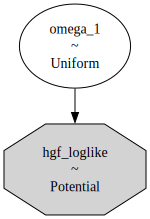

In [10]:
pm.model_to_graphviz(two_level_hgf)

In [67]:
with two_level_hgf:
    idata = pm.sample(chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [omega_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


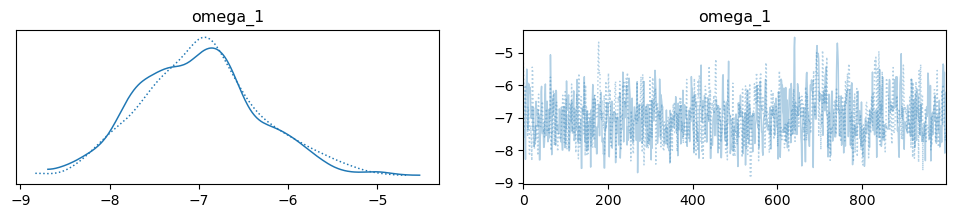

In [12]:
az.plot_trace(idata);

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1,-6.981,0.685,-8.3,-5.734,0.028,0.02,627.0,781.0,1.0


### Practice: Filtering the worlds weather

In the previous section, we introduced the computational concept behind the Hierarchical Gaussian Filter and illustrated:

1. How to create Gaussian Random Walks with hierarchical dependencies.
1. How to fit the HGF to a time series with continuous inputs.
2. How to find the posterior distribution over some parameters given sensory data and a response function.

For the time left before the break, you are going to apply this knowledge to more practical context: filtering the world weather. We will use data from {cite:p}`pfenninger:2016, staffell:2016` that is made available at [the following database](https://renewables.ninja/). This database contains hourly recordings of various weather parameters that have been tracked over one year at a different positions in the world. The data from Aarhus can be loaded using the following function call:

In [66]:
aarhus_weather_df = pd.read_csv("https://raw.githubusercontent.com/ilabcode/hgf-data/main/datasets/weather.csv")
aarhus_weather_df.head()

,time,t2m,prectotland,precsnoland,snomas,rhoa,swgdn,swtdn,cldtot
0,2019-01-01 00:00,7.387,0.124,0.0,0.0,1.249,0.0,0.0,0.931
1,2019-01-01 01:00,7.472,0.200,0.0,0.0,1.247,0.0,0.0,0.865
2,2019-01-01 02:00,7.635,0.196,0.0,0.0,1.244,0.0,0.0,0.701
3,2019-01-01 03:00,7.224,0.061,0.0,0.0,1.245,0.0,0.0,0.387
4,2019-01-01 04:00,6.147,0.018,0.0,0.0,1.250,0.0,0.0,0.128


The data frame contains the following parameters, recorded every hour over the year of 2019:

| parameter | description |
| --- | --- |
| t2m | The 2-meter above ground level air temperature |
| prectotland | The rain precipitation rate (mm/hour) |
| precsnoland | Snow precipitation rate (mm/hour) |
| snomas | Total snow storage land (kg/m2) |
| rhoa | Air density at surface (kg/m3) |
| swgdn | Surface incoming shortwave flux (W/m2) (considering cloud cover) (The value at the surface is approximately 1000 W/m2 on a clear day at solar noon in the summer months) |
| swtdn | Toa (top of atmosphere) incoming shortwave flux (W/m2) |
| cldtot | Total cloud area fraction. An average over grid cells and summed over all height above ground ([0,1] scale where 0 is no cloud and 1 is very cloudy) |

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.
Adding 720 new observations.


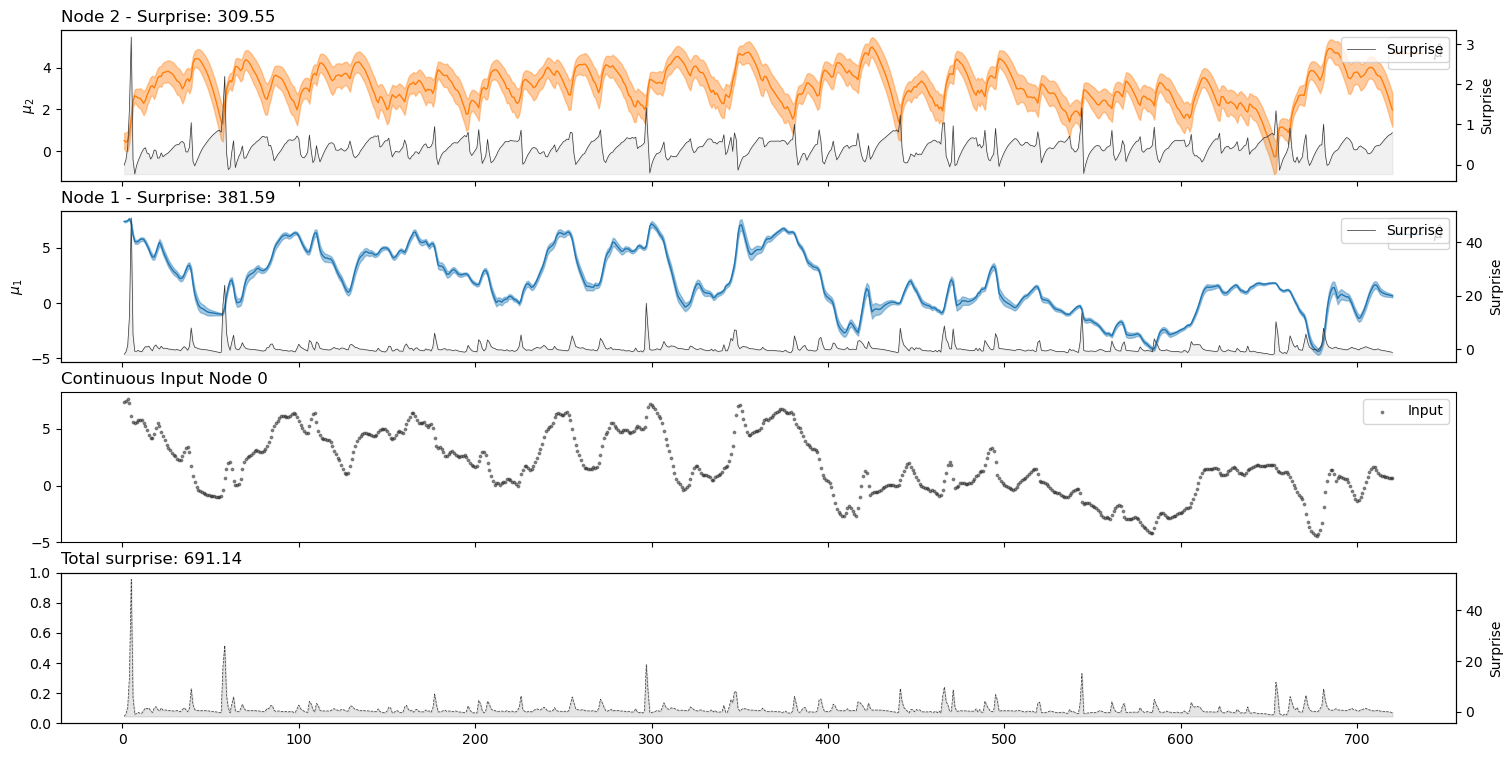

In [15]:
# Load time series example data
timeserie = aarhus_weather_df["t2m"][:24*30].to_numpy()

# This is where we define all the model parameters - You can control the value of
# different variables at different levels using the corresponding dictionary.
hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": timeserie[0], "2": .5},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1":-6.0, "2": -3.0},
)

# add new observations
hgf.input_data(input_data=timeserie)

# visualization of the belief trajectories
hgf.plot_trajectories();

```{admonition} Exercises 4
- Select a city and download a recording OR use the data frame loaded above.
- Fit an agent using one of the variable and compute the posterior probability over this parameter.
```

## Bayesian reinforcement learning: the binary HGF

In [22]:
u, y = load_data("binary")

### The binary Hierarchical Gaussian Filter

In [23]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mu={"1": .0, "2": .5},
    initial_pi={"1": .0, "2": 1e4},
    omega={"2": -3.0},
)

Creating a binary Hierarchical Gaussian Filter with 2 levels.
... Create the update sequence from the network structure.
... Create the belief propagation function.
... Cache the belief propagation function.


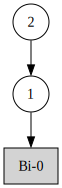

In [24]:
two_levels_hgf.plot_network()

In [25]:
two_levels_hgf = two_levels_hgf.input_data(input_data=u)

Adding 320 new observations.


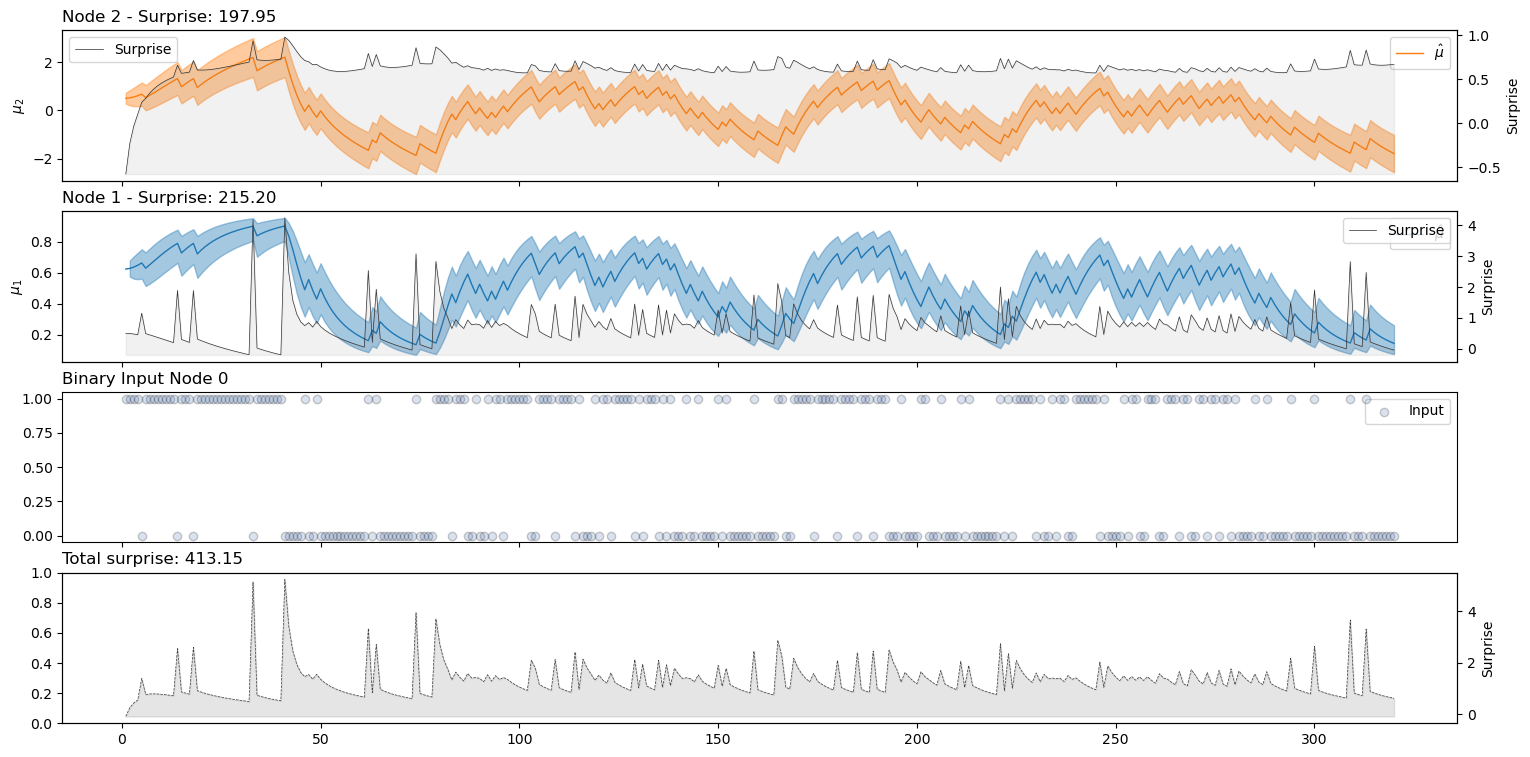

In [26]:
two_levels_hgf.plot_trajectories();

When modelling, we always want to control for alternative, simpler explanations. It might be that our subjects are dynamically updating their beliefs in accordance with our assumptions. However, sometimes, they might just be responding rather randomly and not show much learning at all.

To control for this possibility, we define a simple alternative model below. This model just takes random actions with a single fixed probability. It does not integrate the data from the task at all.

### Biased random

In [27]:
from pyhgf.response import binary_softmax
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor import scan, function

In [28]:
def logp(value, action_probability):

    responses = pt.as_tensor_variable(y, dtype="int32")

    # compute the log probability associated with the actual responses
    logp = pt.sum(pt.log(pt.power(action_probability, responses) * pt.power((1 - action_probability), 1-responses)))

    return logp

In [29]:
with pm.Model() as biased_random_model:
    y_data = pm.ConstantData("y_data", y)
    bias = pm.Beta("bias", 1.0, 1.0)
    biased_random = pm.DensityDist('biased_random', bias, logp=logp, observed=y_data)

In [30]:
with biased_random_model:
    biased_random_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


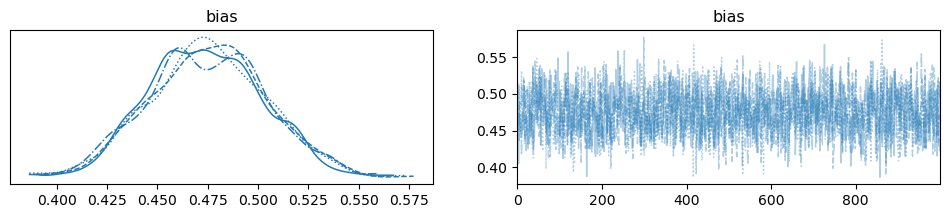

In [31]:
az.plot_trace(biased_random_idata);

In [32]:
az.waic(biased_random_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -222.28     0.00
p_waic        0.50        -

There has been a warning during the calculation. Please check the results.

### A simple Rescorla-Wagner model

In [34]:
def rw_update(new_observation, current_belief, learning_rate):

    # sigmoid transform the beliefs at t-1 (into [0,1])
    transformed_old_value = 1 / (1 + pt.exp(-current_belief))

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (new_observation - transformed_old_value)

    return new_belief

In [35]:
def logp(value, learning_rate, action_precision):

    observations = pt.as_tensor_variable(u, dtype="int32")
    responses = pt.as_tensor_variable(y, dtype="int32")
    outputs_info = pt.as_tensor_variable(np.asarray(0.0, observations.dtype))
    curret_belief = pt.zeros(1, dtype="float")
    
    results, updates = scan(
        fn=rw_update, 
        sequences=observations, 
        non_sequences=[learning_rate],
        outputs_info=[curret_belief]
    )
    
    # pass this belief through softmax to get action probability
    action_probability = 1 / (1 + pt.exp(-action_precision * results))
    
    # compute the log probability associated with the actual responses
    logp = pt.sum(pt.log(pt.power(action_probability[:, 0], responses) * pt.power((1 - action_probability[:, 0]), 1-responses)))

    return logp

In [36]:
with pm.Model() as rw_model:
    y_data = pm.ConstantData("y_data", y)
    lr = pm.Normal("lr", 0.0, 2.0)
    ap = pm.HalfNormal("ap", 5.0)
    hgf = pm.DensityDist('hgf', lr, ap, logp=logp, observed=y_data)

In [37]:
with rw_model:
    rw_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lr, ap]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


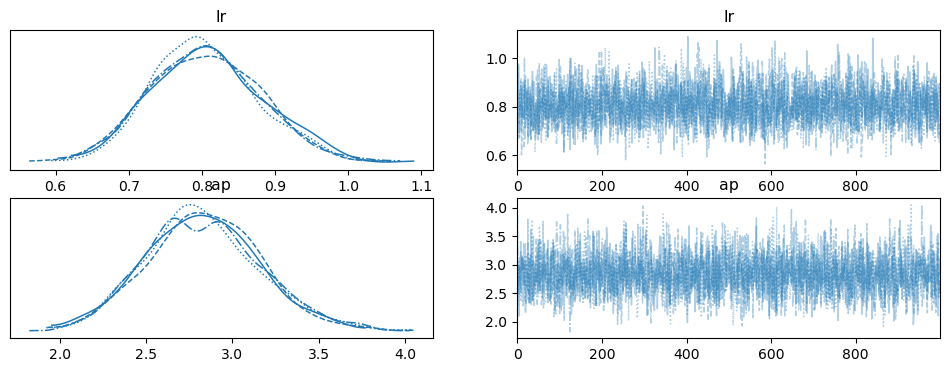

In [38]:
az.plot_trace(rw_idata);

In [39]:
az.waic(rw_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -95.71     0.00
p_waic        0.94        -

There has been a warning during the calculation. Please check the results.

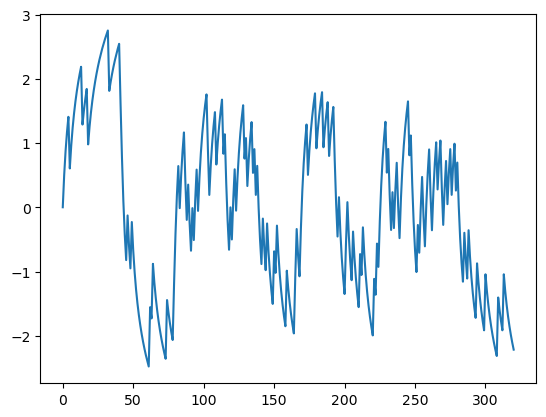

In [41]:
import matplotlib.pyplot as plt
learning_rate = 1.0
action_precision = 2.0
def rw_update(new_observation, current_belief):

    # sigmoid transform the beliefs at t-1 (into [0,1])
    transformed_old_value = 1 / (1 + np.exp(-current_belief))

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (new_observation - transformed_old_value)

    return new_belief

beliefs = [0.0]
for i in u:
    new_belief = rw_update(i, beliefs[-1])
    beliefs.append(new_belief)
plt.plot(beliefs)

### Modelling behaviours using a response function

In [42]:
learning_rate

1.0

### Model comparison

#### Two-level HGF

In [43]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=[u],
    response_function=binary_softmax,
    response_function_parameters=[y],
)

In [44]:
def logp(value, omega_2):
    return hgf_logp_op(
            omega_1=jnp.inf,
            omega_2=omega_2,
            omega_3=jnp.nan,
            continuous_precision=jnp.inf,
            rho_1=0.0,
            rho_2=0.0,
            rho_3=jnp.nan,
            pi_1=0.0,
            pi_2=1e4,
            pi_3=jnp.nan,
            mu_1=jnp.inf,
            mu_2=0.5,
            mu_3=jnp.nan,
            kappa_1=1.0,
            kappa_2=jnp.nan,
        )

In [45]:
with pm.Model() as two_levels_binary_hgf:
    y_data = pm.ConstantData("y_data", y)
    omega_2 = pm.Uniform("omega_2", -4.0, 0.0)
    hgf = pm.DensityDist('hgf', omega_2, logp=logp, observed=y_data)

In [46]:
with two_levels_binary_hgf:
    two_levels_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'omega_2'}>,
        <Axes: title={'center': 'omega_2'}>]], dtype=object)

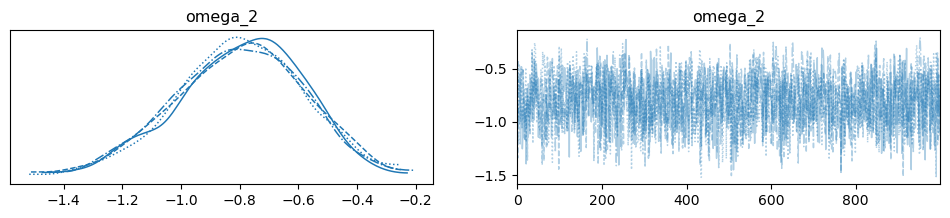

In [47]:
az.plot_trace(two_levels_idata);

In [48]:
az.waic(two_levels_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -113.99     0.00
p_waic        0.40        -

#### Three-level HGF

In [49]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=[u],
    response_function=binary_softmax,
    response_function_parameters=[y]
)

In [50]:
def logp(value, omega_2, omega_3):
    return hgf_logp_op(
            omega_1=jnp.inf,
            omega_2=omega_2,
            omega_3=omega_3,
            continuous_precision=jnp.inf,
            rho_1=0.0,
            rho_2=0.0,
            rho_3=0.0,
            pi_1=0.0,
            pi_2=1e4,
            pi_3=1e1,
            mu_1=jnp.inf,
            mu_2=0.0,
            mu_3=0.0,
            kappa_1=1.0,
            kappa_2=1.0,
        )

In [51]:
with pm.Model() as three_levels_binary_hgf:
    y_data = pm.ConstantData("y_data", y)
    omega_2 = pm.Uniform("omega_2", -4.0, 0.0)
    omega_3 = pm.Normal("omega_3", -4.0, 5.0)
    hgf = pm.DensityDist('hgf', omega_2, omega_3, logp=logp, observed=y_data)

In [52]:
with three_levels_binary_hgf:
    three_levels_idata = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega_2, omega_3]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1582 divergences after tuning. Increase `target_accept` or reparameterize.


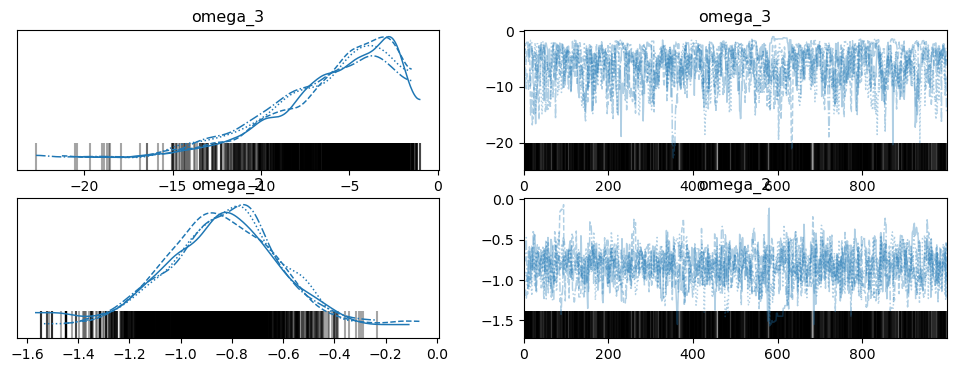

In [53]:
az.plot_trace(three_levels_idata);

In [54]:
az.waic(three_levels_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -114.15     0.00
p_waic        0.72        -

There has been a warning during the calculation. Please check the results.

In [59]:
az.compare(
    {
        "biased_random": biased_random_idata, 
        "RW": rw_idata, 
        "two-level": two_levels_idata, 
        "three-level": three_levels_idata
    }, 
    ic="waic"
)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arvi

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
RW,0,-95.713396,0.942461,0.000000,1.000000e+00,0.0,0.0,True,log
two-level,1,-113.993547,0.398215,18.280151,2.248202e-15,0.0,0.0,False,log
three-level,2,-114.145828,0.718097,18.432432,0.000000e+00,0.0,0.0,True,log
biased_random,3,-222.275456,0.502375,126.562061,8.881784e-15,0.0,0.0,True,log


In [56]:
az.waic(biased_random_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -222.28     0.00
p_waic        0.50        -

There has been a warning during the calculation. Please check the results.

In [57]:
az.waic(two_levels_idata)

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.9/site-packages/arviz/stats/stats.py:1673: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -113.99     0.00
p_waic        0.40        -